# Dataset introduction

The dataset chosen for this project is a celeberity dataset. Through this dataset we will be trying to generate faces and with certain attributes like smiling, young, male or female and so on.

We have 4 different files as described below:

1. **img_align_celeba.zip**: All the face images
2. **list_eval_partition.csv**: Recommended partitioning of images into training, validation, testing sets. Images 1-162770 are training, 162771-182637 are validation, 182638-202599 are testing
3. **list_bbox_celeba.csv**: Bounding box information for each image. "x_1" and "y_1" represent the upper left point coordinate of bounding box. "width" and "height" represent the width and height of bounding box
4. **list_landmarks_align_celeba.csv**: Image landmarks and their respective coordinates. There are 5 landmarks: left eye, right eye, nose, left mouth, right mouth
5. **list_attr_celeba.csv**: Attribute labels for each image. There are 40 attributes. "1" represents positive while "-1" represents negative

In [ ]:
from google.colab import drive

# Mounting Google Drive
drive.mount('/content/drive',force_remount=True)

In [10]:
# Navigating to the directory containing the zip file
%cd /content/drive/MyDrive/Neural_Project_Celeba/

# Unzipping the file
!unzip img_align_celeba.zip

/content/drive/MyDrive/Neural_Project_Celeba


In [200]:
#Importing zipfile for unzipping the dataset file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import os
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import load_img
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
# from google.colab import drive
from keras.layers import Input, Conv2D, Flatten, Dense
from keras.models import Model
from tensorflow.keras.layers import Dropout, Lambda, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU, UpSampling2D
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
import concurrent.futures

The below code is for the file where the attributes of each of the image is given and the corresponding values, where 1 indicates a Yes and -1 ondicates a No.

In [2]:
df_list_attr = pd.read_csv('list_attr_celeba.csv')
# df_list_attr = pd.read_csv('/Users/rashitiwary/Documents/George Washington University/Masters Subject/CSCI  6366 Neural network/Semester Project/Dataset/list_attr_celeba.csv')
df_list_attr.set_index('image_id', inplace=True)
df_list_attr.replace(to_replace=-1, value=0, inplace=True)  # replacing all the attributes of -1 by 0
df_list_attr.shape

(202599, 40)

In [3]:
#Displaying different attributes of the images. In total, there are 40 attributes for each image.
df_list_attr

5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
image_id                                                                     
000001.jpg                 0                1           1                0   
000002.jpg                 0                0           0                1   
000003.jpg                 0                0           0                0   
000004.jpg                 0                0           1                0   
000005.jpg                 0                1           1                0   
...                      ...              ...         ...              ...   
202595.jpg                 0                0           1                0   
202596.jpg                 0                0           0                0   
202597.jpg                 0                0           0                0   
202598.jpg                 0                1           1                0   
202599.jpg                 0                1           1                0   

            Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  Blond_Hair  ...  \
image_id                                                             ...   
000001.jpg     0      0         0         0           0           0  ...   
000002.jpg     0      0         0         1           0           0  ...   
000003.jpg     0      0         1         0           0           0  ...   
000004.jpg     0      0         0         0           0           0  ...   
000005.jpg     0      0         1         0           0           0  ...   
...          ...    ...       ...       ...         ...         ...  ...   
202595.jpg     0      0         1         0           0           1  ...   
202596.jpg     0      1         1         0           0           1  ...   
202597.jpg     0      0         0         0           1           0  ...   
202598.jpg     0      0         1         0           1           0  ...   
202599.jpg     0      0         0         0           0           1  ...   

            Sideburns  Smiling  Straight_Hair  Wavy_Hair  Wearing_Earrings  \
image_id                                                                     
000001.jpg          0        1              1          0                 1   
000002.jpg          0        1              0          0                 0   
000003.jpg          0        0              0          1                 0   
000004.jpg          0        0              1          0                 1   
000005.jpg          0        0              0          0                 0   
...               ...      ...            ...        ...               ...   
202595.jpg          0        0              0          0                 0   
202596.jpg          0        1              1          0                 0   
202597.jpg          0        1              0          0                 0   
202598.jpg          0        1              0          1                 1   
202599.jpg          0        0              0          1                 0   

            Wearing_Hat  Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie  \
image_id                                                                       
000001.jpg            0                 1                 0                0   
000002.jpg            0                 0                 0                0   
000003.jpg            0                 0                 0                0   
000004.jpg            0                 1                 1                0   
000005.jpg            0                 1                 0                0   
...                 ...               ...               ...              ...   
202595.jpg            0                 1                 0                0   
202596.jpg            0                 0                 0                0   
202597.jpg            0                 0                 0                0   
202598.jpg            0                 1                 0                0   
202599.jpg            0          

The image below plotted shows different details, and it appears based on whether the details have a '1', meaning 'Yes'. This makes it easier to understand and learn about the different details in the file.

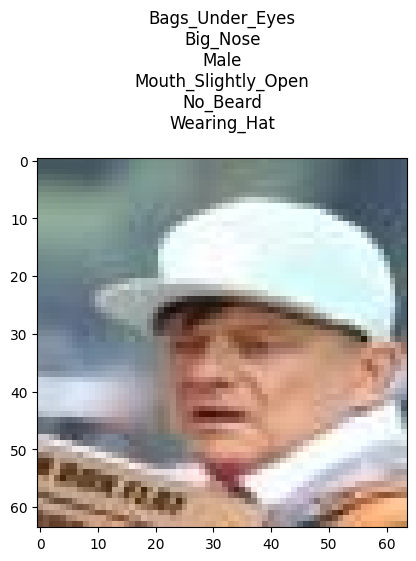

In [4]:
label = ''
# img = load_img('/Users/rashitiwary/Documents/George Washington University/Masters Subject/CSCI  6366 Neural network/Semester Project/Dataset/img_align_celeba/img_align_celeba/054810.jpg')
img = load_img('img_align_celeba/054810.jpg')
row_index = df_list_attr.index.get_loc('054810.jpg')

for col in df_list_attr.columns:
    if df_list_attr.loc['054810.jpg', col] == 1:
        label += col + '\n'

plt.imshow(img)
plt.title(label)
plt.show()

The below code is of the file list_eval_partition.csv. This file contains the partition of the data in training, validation and testing dataset.

In [5]:
#Overview of list_eval_partition.csv
df_partition_list = pd.read_csv('list_eval_partition.csv')
# df_partition_list = pd.read_csv('/Users/rashitiwary/Documents/George Washington University/Masters Subject/CSCI  6366 Neural network/Semester Project/Dataset/list_eval_partition.csv')
df_partition_list.head()

image_id  partition
0  000001.jpg          0
1  000002.jpg          0
2  000003.jpg          0
3  000004.jpg          0
4  000005.jpg          0

In [6]:
#Partition columns is defined as follows: 0 for training, 1 for validation and 2 for testing dataset
df_partition_list.groupby('partition').size().sort_index()

partition
0    162770
1     19867
2     19962
dtype: int64

In [18]:
#Resizing the images to (64,64)

# directory_path = '/Users/rashitiwary/Documents/George Washington University/Masters Subject/CSCI  6366 Neural network/Semester Project/Dataset/img_align_celeba/img_align_celeba/'
directory_path = '/content/drive/MyDrive/img_align_celeba/img_align_celeba'  
image_list = os.listdir(directory_path)
for image in image_list:

    # Construct the full file path
    image_path = os.path.join(directory_path, image)

    # Open the image using Pillow
    image = Image.open(image_path)

    # Resize the image to (64, 64)
    resized_image = image.resize((64, 64))

    # Save the resized image, overwriting the original file
    resized_image.save(image_path)

In [7]:
img = load_img('img_align_celeba/081169.jpg')
# img = load_img('/Users/rashitiwary/Documents/George Washington University/Masters Subject/CSCI  6366 Neural network/Semester Project/Dataset/img_align_celeba/img_align_celeba/134526.jpg')
img_array = np.array(img)
print("Image shape:", img_array.shape)

Image shape: (64, 64, 3)


In [196]:
#Functions for pre-processing the dataset and plotting the images

def parse_image(data):
    img = tf.io.read_file(data)
    img = tf.image.decode_jpeg(img, channels=3)
    
    shapes = tf.shape(img)
    h, w = shapes[-3], shapes[-2]
    small = tf.minimum(h, w)
    
    img = tf.image.convert_image_dtype(img, tf.float32) 
    img = tf.image.resize_with_crop_or_pad(img, small, small) 
    img = tf.image.resize(img, [64, 64], antialias=True)
    return img

def plot_image(images): 
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0.01,hspace=0.01)
    for i in range(36):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
        
def plot_reconstructed(original, reconstructed): 
    images = np.concatenate([original, reconstructed])
    fig = plt.figure(figsize=(10, 5))
    grid = ImageGrid(fig, 111, nrows_ncols=(2, 6), axes_pad=0, share_all=True)
    grid[0].get_yaxis().set_ticks([])
    grid[0].get_xaxis().set_ticks([])
    for ax, im in zip(grid, images):
        ax.imshow(im)
    plt.show()

In [10]:
#Splitting data into training, validation and testing dataset
#df_partition_list contains the partition of test,training and validation datasets

directory_path = './img_align_celeba/'
# directory_path = '/Users/rashitiwary/Documents/George Washington University/Masters Subject/CSCI  6366 Neural network/Semester Project/Dataset/img_align_celeba/img_align_celeba/'
batch_size = 128

def load_image(file_path):
    im = load_img(file_path)
    return np.array(im)

#Usage of Python's concurrent threads ability
with concurrent.futures.ThreadPoolExecutor() as executor:
    train_data_list = list([directory_path + i for i in df_partition_list[df_partition_list['partition'] == 0]['image_id']])
    validation_data_list = list([directory_path + i for i in df_partition_list[df_partition_list['partition'] == 1]['image_id']])
    test_data_list = list([directory_path + i for i in df_partition_list[df_partition_list['partition'] == 2]['image_id']])
        
    train_data = tf.data.Dataset.from_tensor_slices(train_data_list)
    validation_data = tf.data.Dataset.from_tensor_slices(validation_data_list)
    test_data = tf.data.Dataset.from_tensor_slices(test_data_list)
    
    
train_ds = train_data.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.cache().shuffle(len(train_data)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = validation_data.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(len(validation_data)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_data.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(len(test_data)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# retrieve a batch of images
train_batch = next(iter(train_ds))

In [42]:
print(train_batch.shape)

(128, 64, 64, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>


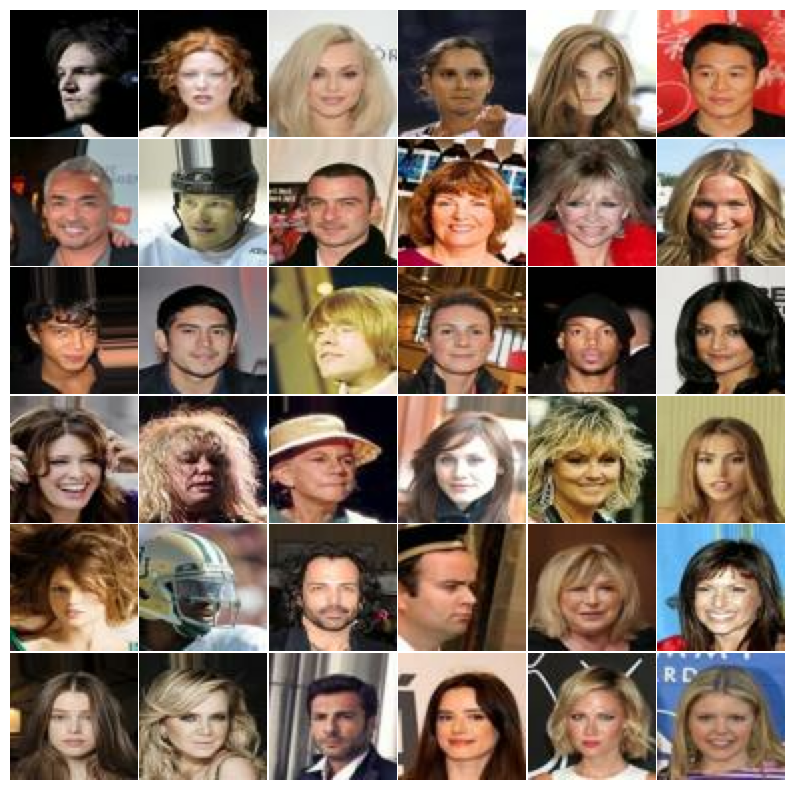

In [11]:
plot_image(train_batch.numpy())

In [152]:
#Building encoder
latent_dim = 100
input_shape = (64,64,3)

encoder_input = Input(shape=input_shape, name='encoder_input')

x = Conv2D(64, (3, 3), strides=2, padding='same', kernel_initializer='he_normal')(encoder_input)
x = BatchNormalization()(x) 
x = LeakyReLU(0.2)(x)

x = Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x) 
x = LeakyReLU(0.2)(x)

x = Conv2D(256, (3, 3), strides=2, padding='same')(x)
x = BatchNormalization()(x) 
x = LeakyReLU(0.2)(x)

convolution_shape = keras.backend.int_shape(x)

x = Flatten(data_format='channels_last')(x)

x = Dense(2048)(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

# Parameters for the VAE
z_mean = Dense(latent_dim, activation=None)(x)
z_log_var = Dense(latent_dim, activation=None)(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(1, 100), mean=0., stddev=0.1)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

# Create the encoder model
encoder_model = Model(encoder_input, [z_mean, z_log_var, z], name='encoder_model')

encoder_model.summary()

Model: "encoder_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_39 (Conv2D)          (None, 32, 32, 64)           1792      ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization_35 (Ba  (None, 32, 32, 64)           256       ['conv2d_39[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 leaky_re_lu_63 (LeakyReLU)  (None, 32, 32, 64)           0         ['batch_normalizat

In [153]:
# Decoder

decoder_input = Input(shape = (latent_dim), name = 'decoder_input')

x = Dense(2048)(decoder_input)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = Dense(16384)(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = Reshape((convolution_shape[1], convolution_shape[2], convolution_shape[3]))(x)

x = Conv2DTranspose(128,(3, 3), padding='same', strides=(2,2), kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = Conv2DTranspose(64,(3, 3), padding='same', strides=(2, 2), kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = Conv2DTranspose(32,(3, 3), padding='same', strides=(2, 2), kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = Conv2DTranspose(3,(3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal')(x)

decoder_model = Model(decoder_input, x, name = 'decoder')

decoder_model.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 100)]             0         
                                                                 
 dense_47 (Dense)            (None, 2048)              206848    
                                                                 
 batch_normalization_39 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_67 (LeakyReLU)  (None, 2048)              0         
                                                                 
 dense_48 (Dense)            (None, 16384)             33570816  
                                                                 
 batch_normalization_40 (Ba  (None, 16384)             65536     
 tchNormalization)                                         

In [154]:
#Loss function for our VAE which is the combination of reconstruction loss and KL divergence loss

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
    # def __init__(self, preprocesser, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.alpha = 1.8
        self.beta = 10
        # self.preprocessor = preprocesser
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
        
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # reconstruction_loss = tf.reduce_mean(keras.losses.mean_squared_error(data, reconstruction))
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = self.alpha * reconstruction_loss + self.beta * kl_loss
            # total_loss = reconstruction_loss + kl_loss           
        
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
        
    def call(self, data):
        # data = self.preprocessor(data)
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        # reconstruction_loss = tf.reduce_mean(keras.losses.mean_squared_error(data, reconstruction))
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = self.alpha * reconstruction_loss + self.beta * kl_loss
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "reconstruction": reconstruction
        }

In [155]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_total_loss', factor=0.2, patience=2, verbose=1, mode='min'),
             tf.keras.callbacks.EarlyStopping(monitor="val_total_loss", patience=15, mode="min", verbose=1)]

In [156]:
#Building the VAE model
vae = VAE(encoder_model, decoder_model)
vae.compile(optimizer=tf.keras.optimizers.legacy.Adam(1e-4))
vae_history = vae.fit(train_ds, epochs=20, batch_size=batch_size, validation_data=(val_ds, None), callbacks=callbacks)

Epoch 1/20


1272/1272 [==============================] - 536s 421ms/step - loss: 4187.6885 - reconstruction_loss: 2190.1541 - kl_loss: 3.4156 - val_total_loss: 3870.8958 - val_reconstruction_loss: 2128.0117 - val_kl_loss: 4.0477 - lr: 1.0000e-04
Epoch 2/20
1272/1272 [==============================] - 519s 407ms/step - loss: 3833.4405 - reconstruction_loss: 2101.8247 - kl_loss: 4.1630 - val_total_loss: 3819.1479 - val_reconstruction_loss: 2097.3420 - val_kl_loss: 4.3931 - lr: 1.0000e-04
Epoch 3/20
1272/1272 [==============================] - 516s 406ms/step - loss: 3804.7945 - reconstruction_loss: 2087.1519 - kl_loss: 4.3869 - val_total_loss: 3810.7825 - val_reconstruction_loss: 2092.8677 - val_kl_loss: 4.3620 - lr: 1.0000e-04
Epoch 4/20
1272/1272 [==============================] - 516s 406ms/step - loss: 3790.0047 - reconstruction_loss: 2079.6262 - kl_loss: 4.5084 - val_total_loss: 3795.9075 - val_reconstruction_loss: 2084.5664 - val_kl_loss: 4.3689 - lr: 1.0000e-04
Epoch 5/20
1272/1272 [=========

In [157]:
#Function for displaying the history of the VAE model loss

def display_history(history):
    
    fig=plt.figure(figsize=(20,5))

    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history['reconstruction_loss'])
    plt.plot(history.history['val_reconstruction_loss'])
    plt.title('reconstruction_loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history['kl_loss'])
    plt.plot(history.history['val_kl_loss'])
    plt.title('kl_loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

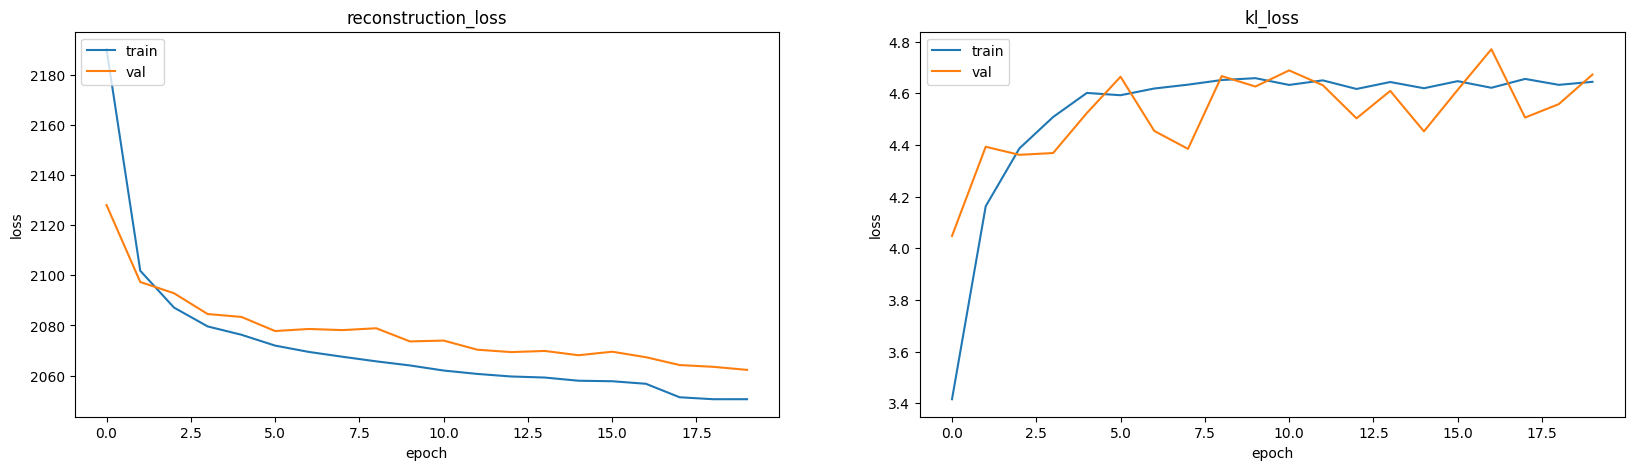

In [158]:
display_history(vae_history)

1/1 [==============================] - 0s 220ms/step


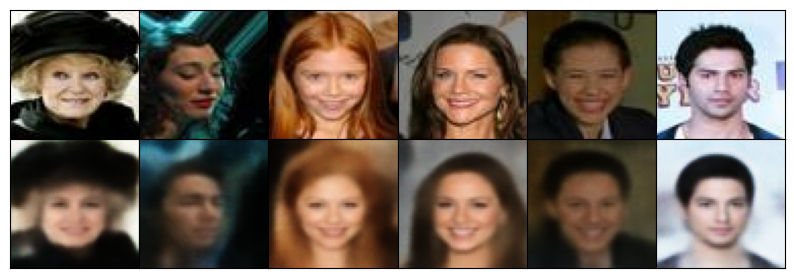

In [159]:
# Testing our VAE model over the test data

test_ds1 = tf.data.Dataset.from_tensor_slices(test_data_list[:6])

test_ds2 = test_ds1.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds2 = test_ds2.cache().batch(6).prefetch(buffer_size=tf.data.AUTOTUNE)
test_batch = next(iter(test_ds2))

# Reconstructed images
encoded_data  = vae.encoder.predict(test_ds2)
decoded_data  = vae.decoder.predict(encoded_data[0])
plot_reconstructed(test_batch.numpy(),decoded_data)

2/2 [==============================] - 0s 11ms/step


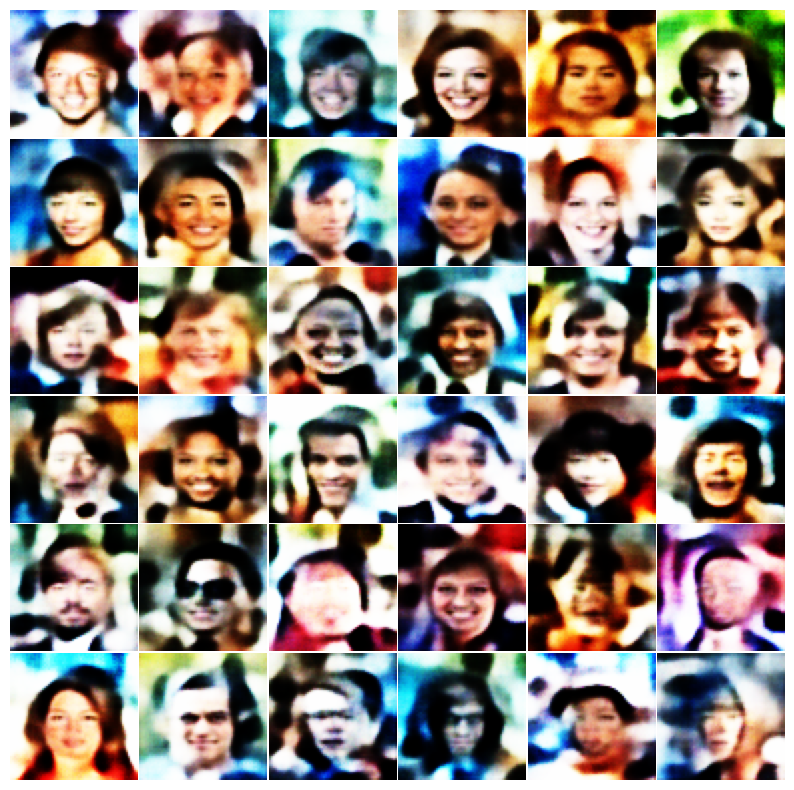

In [160]:
# Faces generated from random noise

random_latent_vectors = tf.random.normal(shape=(36,latent_dim))
random_generated = vae.decoder.predict(random_latent_vectors)
plot_image(random_generated)

1/1 [==============================] - 0s 12ms/step


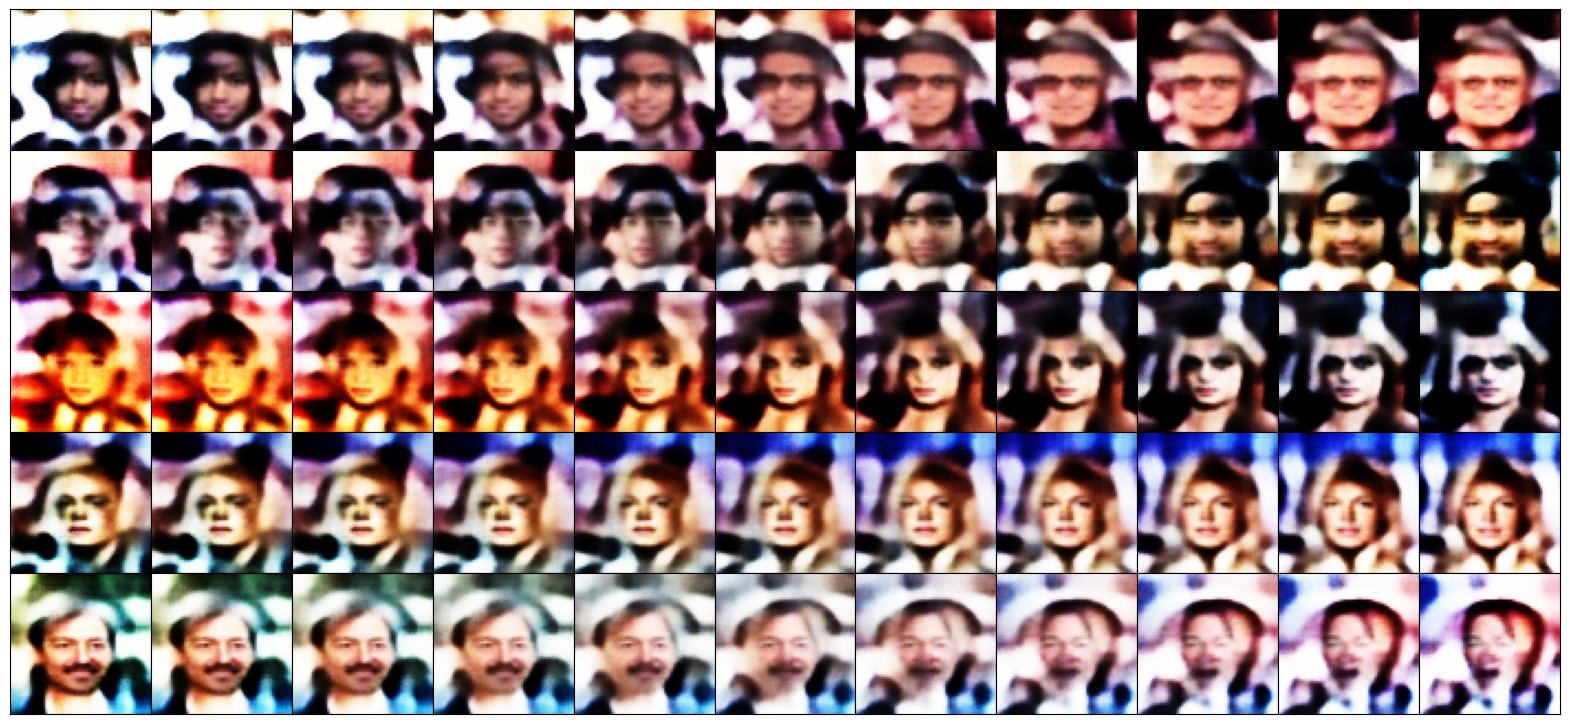

In [161]:
def plot_latent_space(n=5): 
    output_list = []
    for i in range(n):
        z1 = tf.random.normal([1,latent_dim],0.0 ,1.0)
        z2 = tf.random.normal([1,latent_dim],0.0 ,1.0)
        for j in range(11):
            z_in = (j/10) * z1 + (1 - (j/10)) * z2
            output = vae.decoder.predict(z_in)
            output_list.append(output[0])
            
    images = np.array(output_list)
    
    fig = plt.figure(figsize=(20, n*2))
    grid = ImageGrid(fig, 111, nrows_ncols=(n, 11), axes_pad=0, share_all=True)
    grid[0].get_yaxis().set_ticks([])
    grid[0].get_xaxis().set_ticks([])
    for ax, im in zip(grid, images):
        ax.imshow(im)
    plt.show()
    
plot_latent_space(5)

624/624 [==============================] - 15s 25ms/step


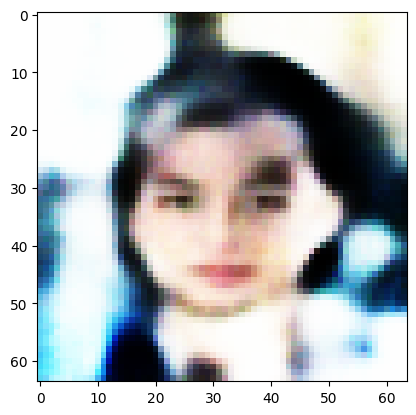

In [163]:
def sample_latent_space(z_mean, z_log_var):
    batch, latent_dim = z_mean.shape
    epsilon = np.random.normal(size=(batch, latent_dim))
    return z_mean + np.exp(0.5 * z_log_var) * epsilon

def get_z_mean_z_log_var(input_image):
    z_mean, z_log_var, _ = vae.encoder.predict(input_image)
    return z_mean, z_log_var


z_mean_value, z_log_var_value = get_z_mean_z_log_var(test_ds)

latent_vector = sample_latent_space(z_mean_value, z_log_var_value)

generated_image = vae.decoder.predict(latent_vector)

plt.imshow(generated_image[0])
plt.show()

In [164]:
encoder_model.save('encoder_model.h5')
decoder_model.save('decoder_model.h5')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [165]:
#Adding noise layer for better discriminator learning

from tensorflow.keras.layers import Layer

class GaussianNoise(Layer):
    def __init__(self, stddev, **kwargs):
        super(GaussianNoise, self).__init__(**kwargs)
        self.stddev = stddev

    def call(self, inputs, training=None):
        if training:
            noise = tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=self.stddev)
            return inputs + noise
        else:
            return inputs

    def get_config(self):
        config = super(GaussianNoise, self).get_config()
        config.update({'stddev': self.stddev})
        return config

In [176]:
# Discriminator model
discriminator_input = Input(shape=(latent_dim,), name='discriminator_input')
noise_stddev = 0.1  

#Do the 'training = False' in the noisy_input while testing the network
noisy_input = GaussianNoise(stddev=noise_stddev)(discriminator_input, training=False)

x = Dense(512, activation='relu', kernel_initializer='he_normal')(noisy_input)
x = LeakyReLU(alpha=0.3)(x)

x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = LeakyReLU(alpha=0.3)(x)

x = Dense(256, activation='relu', kernel_initializer='he_normal')(x)
x = LeakyReLU(alpha=0.3)(x)

x = Dense(128, activation='relu', kernel_initializer='he_normal')(x)
x = LeakyReLU(alpha=0.3)(x)

x = Dense(64, activation='relu', kernel_initializer='he_normal')(x)
x = LeakyReLU(alpha=0.3)(x)
x = Dropout(0.3)(x)

x = Dense(1, activation='sigmoid', name='discriminator_output', kernel_initializer='glorot_normal')(x)

discriminator_model = Model(discriminator_input, x, name='discriminator_model')

In [177]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0)
discriminator_model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics=['accuracy'])
discriminator_model.summary()

Model: "discriminator_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator_input (Input  [(None, 100)]             0         
 Layer)                                                          
                                                                 
 gaussian_noise_4 (Gaussian  (None, 100)               0         
 Noise)                                                          
                                                                 
 dense_59 (Dense)            (None, 512)               51712     
                                                                 
 leaky_re_lu_82 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_60 (Dense)            (None, 512)               262656    
                                                                 
 leaky_re_lu_83 (LeakyReLU)  (None, 512)       

In [178]:
# The adversarial_autoencoder model

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, clipnorm=1.0)
z_output = vae.encoder(encoder_input)[2]  # Taking only the third output, which is `z` , latent_vector
aae_output = discriminator_model(z_output) #Takes in latent_vector and outputs probability of the latent vector being real
adversarial_ae = Model(inputs=encoder_input, outputs=[vae.decoder(z_output), aae_output])
adversarial_ae.compile(loss=['mse', 'binary_crossentropy'], optimizer=optimizer)

adversarial_ae.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 encoder_model (Functional)  [(None, 100),                3434708   ['encoder_input[0][0]']       
                              (None, 100),                0                                       
                              (None, 100)]                                                        
                                                                                                  
 decoder (Functional)        (None, 64, 64, 3)            3424045   ['encoder_model[2][2]']       
                                                          1                                

In [146]:
#Some more adversarial code settings
def sample_prior(latent_dim, batch_size):
    return np.random.normal(size=(batch_size, latent_dim))

In [174]:
epochs = 10

epoch_d_losses = []
epoch_g_losses = []

for epoch in range(epochs):
    # Initialize loss accumulators
    d_loss_accumulator = []
    g_loss_accumulator = []

    # Iterate over the training dataset
    for batch_images in train_ds:

        # Generate "fake" latent representations using the encoder
        latent_fake = vae.encoder.predict(batch_images)[2]

        # Generate "true" samples from your prior distribution
        latent_real = sample_prior(latent_dim, batch_images.shape[0])  

        # Train the discriminator on real and fake data
        discriminator_model.trainable = True  # Unfreeze discriminator
        vae.encoder.trainable = False        # Freeze encoder
        d_loss_real = discriminator_model.train_on_batch(latent_real, np.ones((batch_images.shape[0], 1)))
        d_loss_fake = discriminator_model.train_on_batch(latent_fake, np.zeros((batch_images.shape[0], 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        d_loss_accumulator.append(d_loss)

        # Train the adversarial autoencoder
        discriminator_model.trainable = False  # Freeze discriminator
        vae.encoder.trainable = True           # Unfreeze encoder
        #The first target below indicates that the encoder-decoder part of the model is being trained to reconstruct the input images
        #The second target(in closed arguments) indicates that we are training the encoder to fool the discriminator into believing that the generated latent representations are real
        g_loss = adversarial_ae.train_on_batch(batch_images, [batch_images, np.ones((batch_images.shape[0], 1))])  
        g_loss_accumulator.append(g_loss)

    # Calculate average losses
    avg_d_loss = np.mean(d_loss_accumulator, axis=0)
    avg_g_loss = np.mean(g_loss_accumulator, axis=0)

    epoch_d_losses.append(avg_d_loss[0])  # Storing discriminator loss
    epoch_g_losses.append(avg_g_loss)      # Storing generator loss

    print("avg_d_loss:", avg_d_loss)
    print("avg_g_loss:", avg_g_loss)


    # Printing the losses for every epoch
    print("Epoch %d [D loss: %f, acc: %.2f%%] [G loss: %f]" % (epoch, avg_d_loss[0], 100 * avg_d_loss[1], avg_g_loss if np.isscalar(avg_g_loss) else avg_g_loss[0]))



3/3 [==============================] - 0s 19ms/step
avg_d_loss: [0.88326242 0.50494423]
avg_g_loss: [0.94108227 0.50485135 0.43623091]
Epoch 0 [D loss: 0.883262, acc: 50.49%] [G loss: 0.941082]
3/3 [==============================] - 0s 17ms/step
avg_d_loss: [1.14201129 0.48275084]
avg_g_loss: [0.85148941 0.50377389 0.34771551]
Epoch 1 [D loss: 1.142011, acc: 48.28%] [G loss: 0.851489]
3/3 [==============================] - 0s 17ms/step
avg_d_loss: [1.4514872  0.45428163]
avg_g_loss: [0.76656593 0.50298513 0.2635808 ]
Epoch 2 [D loss: 1.451487, acc: 45.43%] [G loss: 0.766566]
3/3 [==============================] - 0s 17ms/step
avg_d_loss: [1.89803038 0.49005993]
avg_g_loss: [0.63869988 0.50319635 0.13550352]
Epoch 3 [D loss: 1.898030, acc: 49.01%] [G loss: 0.638700]
3/3 [==============================] - 0s 17ms/step
avg_d_loss: [2.9302136  0.45699747]
avg_g_loss: [0.58657782 0.50187199 0.08470583]
Epoch 4 [D loss: 2.930214, acc: 45.70%] [G loss: 0.586578]
3/3 [=========================

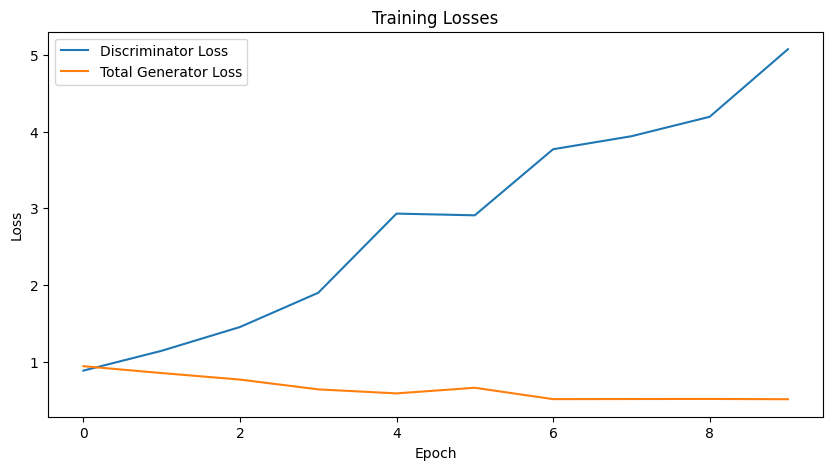

In [181]:
# Plot the losses after training

# Extracting the total generator loss for each epoch
epoch_total_g_losses = [loss_array[0] for loss_array in epoch_g_losses]

# Plotting the discriminator and total generator losses
plt.figure(figsize=(10, 5))
plt.plot(epoch_d_losses, label="Discriminator Loss")
plt.plot(epoch_total_g_losses, label="Total Generator Loss")
plt.title("Training Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [197]:
#Initialize metrics for evaluation on validation dataset

val_d_loss_accumulator = []
val_g_loss_accumulator = []

for batch_images in val_ds:

    # Generate "fake" latent representations using the encoder
    latent_fake = vae.encoder(batch_images, training=False)[2]

    # Generate "true" samples from your prior distribution
    latent_real = sample_prior(latent_dim, batch_images.shape[0])

    # Evaluate the discriminator on real and fake data
    d_loss_real = discriminator_model.evaluate(latent_real, np.ones((batch_images.shape[0], 1)), verbose=0)
    d_loss_fake = discriminator_model.evaluate(latent_fake, np.zeros((batch_images.shape[0], 1)), verbose=0)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    val_d_loss_accumulator.append(d_loss)

    # Evaluate the adversarial autoencoder (generator)
    g_loss = adversarial_ae.evaluate(batch_images, [batch_images, np.ones((batch_images.shape[0], 1))], verbose=0)
    val_g_loss_accumulator.append(g_loss)

# Calculate average test losses
avg_val_d_loss = np.mean(val_d_loss_accumulator, axis=0)
avg_val_g_loss = np.mean(val_g_loss_accumulator, axis=0)

print("avg_val_d_loss:", avg_val_d_loss)
print("avg_val_g_loss:", avg_val_g_loss)


avg_val_d_loss: [2.53263985 0.50032552]
avg_val_g_loss: [0.07740318 0.00780421 0.06959898]


In [198]:
#Printing avergae loss for discriminator and generator as well as accuracy of the discriminator for validation dataset
print("[D loss: %f, acc: %.2f%%] [G loss: %f]" % (avg_val_d_loss[0], 100 * avg_val_d_loss[1], avg_val_g_loss if np.isscalar(avg_val_g_loss) else avg_val_g_loss[0]))

[D loss: 2.532640, acc: 50.03%] [G loss: 0.077403]


In [191]:
# Initialize metrics for evaluation on test dataset

test_d_loss_accumulator = []
test_g_loss_accumulator = []

for batch_images in test_ds:

    # Generate "fake" latent representations using the encoder
    latent_fake = vae.encoder(batch_images, training=False)[2]

    # Generate "true" samples from your prior distribution
    latent_real = sample_prior(latent_dim, batch_images.shape[0])

    # Evaluate the discriminator on real and fake data
    d_loss_real = discriminator_model.evaluate(latent_real, np.ones((batch_images.shape[0], 1)), verbose=0)
    d_loss_fake = discriminator_model.evaluate(latent_fake, np.zeros((batch_images.shape[0], 1)), verbose=0)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    test_d_loss_accumulator.append(d_loss)

    # Evaluate the adversarial autoencoder (generator)
    g_loss = adversarial_ae.evaluate(batch_images, [batch_images, np.ones((batch_images.shape[0], 1))], verbose=0)
    test_g_loss_accumulator.append(g_loss)

# Calculate average test losses
avg_test_d_loss = np.mean(test_d_loss_accumulator, axis=0)
avg_test_g_loss = np.mean(test_g_loss_accumulator, axis=0)

print("avg_test_d_loss:", avg_test_d_loss)
print("avg_test_g_loss:", avg_test_g_loss)


avg_test_d_loss: [2.57933931 0.4983962 ]
avg_test_g_loss: [0.07007947 0.00778121 0.06229826]


In [194]:
#Printing avergae loss for discriminator and generator as well as accuracy of the discriminator for test dataset
print("[D loss: %f, acc: %.2f%%] [G loss: %f]" % (avg_test_d_loss[0], 100 * avg_test_d_loss[1], avg_test_g_loss if np.isscalar(avg_test_g_loss) else avg_test_g_loss[0]))

[D loss: 2.579339, acc: 49.84%] [G loss: 0.070079]


4/4 [==============================] - 0s 26ms/step


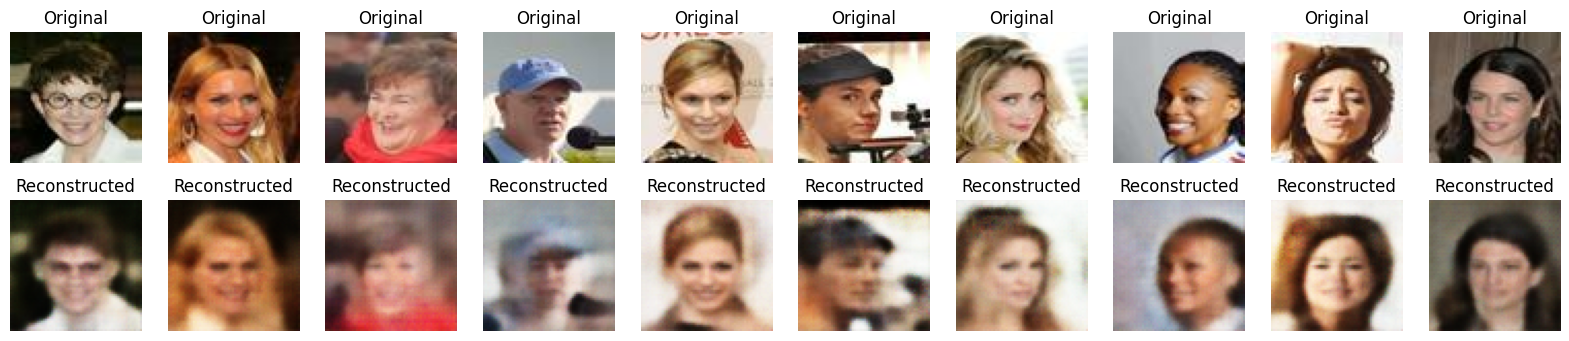

In [195]:
n = 10  # Plotting for 10 images
test_images = next(iter(test_ds.take(n)))

# Generate reconstructed images
latent_vectors = vae.encoder.predict(test_images)

# Pass test images through encoder and then through decoder
reconstructed_images = vae.decoder.predict(latent_vectors[0])

# Plotting
plt.figure(figsize=(20, 4))
for i in range(n):
    # Convert EagerTensor to numpy array and reshape
    original_image = test_images[i].numpy().reshape(64, 64, 3)
    recon_image = reconstructed_images[i].reshape(64, 64, 3)

    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(original_image)
    plt.title("Original")
    plt.axis('off')

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_image)
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()
